# Import Libraries

In [1]:
import pandas as pd
import numpy as np

# Import Dataset

In [2]:
df = pd.read_csv('HousingData.csv')

In [3]:
df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,NaN,36.2


# Data Cleaning

Untuk saat ini dilakukan drop duplikat dan missing values.

Nantinya data cleaning dilakukan sesuai dengan konteks datanya.

In [4]:
df = df.drop_duplicates()

In [5]:
df = df.dropna()

# Model Preparation

Sebelum melakukan prediksi, terlebih dahulu harus ditentukan mana kolom yang menjadi feature dan target.

Dalam hal ini kita akan menggunakan `MEDV` sebagai target dan lainnya sebagai feature.

## Split Feature dan Target

In [6]:
X = df.drop(columns='MEDV') # Feature untuk memprediksi
y = df[['MEDV']] # Target yang akan diprediksi

## Train-Test-Validation Split

In [7]:
from sklearn.model_selection import train_test_split

X_pretrain, X_test, y_pretrain, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

X_train, X_validation, y_train, y_validation = train_test_split(X_pretrain, y_pretrain, test_size=0.20, random_state=42)

In [8]:
X_train.shape, X_validation.shape,  X_test.shape, y_train.shape, y_validation.shape, y_test.shape

((252, 13), (63, 13), (79, 13), (252, 1), (63, 1), (79, 1))

## Multicollinearity Check

In [9]:
# calculate VIF scores for each feature
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif
from statsmodels.tools.tools import add_constant

X_vif = add_constant(X_train)

vif_df = pd.DataFrame([vif(X_vif.values, i)
               for i in range(X_vif.shape[1])],
              index=X_vif.columns).reset_index()
vif_df.columns = ['feature','vif_score']
vif_df = vif_df.loc[vif_df.feature!='const']
vif_df

,feature,vif_score
1,CRIM,1.717769
2,ZN,2.363696
3,INDUS,4.275074
4,CHAS,1.052106
5,NOX,4.468933
6,RM,2.498057
7,AGE,3.252113
8,DIS,4.095015
9,RAD,6.939309
10,TAX,9.277690


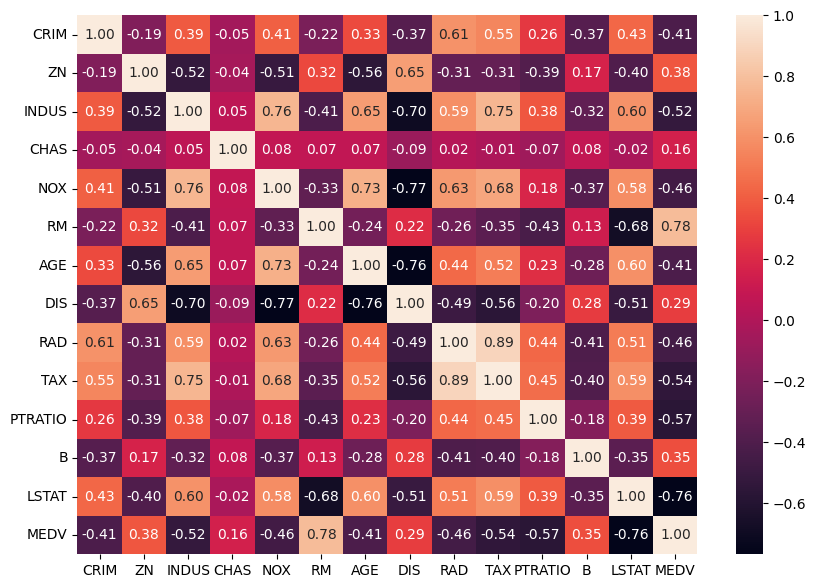

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

# heatmap correlation
data_train = pd.concat([X_train, y_train], axis=1)
corr = data_train.corr()

plt.figure(figsize=(10,7))
sns.heatmap(corr, annot=True, fmt='.2f')
plt.show()

`TAX` dan `RAD` mempunyai nilai vif score cukup tinggi.

`TAX` dan `RAD` mempunyai korelasi yang kuat. `TAX` mempunyai korelasi yang lebih kuat terhadap target yaitu `MEDV` dibandingkan `RAD`, sehingga dipilih `RAD` untuk didrop.

In [11]:
X_train = X_train.drop(columns=['RAD'])
X_validation = X_validation.drop(columns=['RAD'])
X_test = X_test.drop(columns=['RAD'])

## Recheck multicollinearity

In [12]:
# calculate VIF scores for each feature
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif
from statsmodels.tools.tools import add_constant

X_vif = add_constant(X_train)

vif_df = pd.DataFrame([vif(X_vif.values, i)
               for i in range(X_vif.shape[1])],
              index=X_vif.columns).reset_index()
vif_df.columns = ['feature','vif_score']
vif_df = vif_df.loc[vif_df.feature!='const']
vif_df

,feature,vif_score
1,CRIM,1.572375
2,ZN,2.280399
3,INDUS,3.751441
4,CHAS,1.039055
5,NOX,4.144426
6,RM,2.427114
7,AGE,3.217707
8,DIS,4.052477
9,TAX,3.769134
10,PTRATIO,1.793347


Tidak ada lagi vif score yang tinggi

# Ridge Regression

## Train Multiple Models
with different alpha (lambda)

In [13]:
from sklearn.linear_model import Ridge

# define the model
ridge_reg_pointzeroone = Ridge(alpha=0.01, random_state=42)
ridge_reg_pointone = Ridge(alpha=0.1, random_state=42)
ridge_reg_one = Ridge(alpha=1, random_state=42)
ridge_reg_ten = Ridge(alpha=10, random_state=42)

# fit the model (training)
ridge_reg_pointzeroone.fit(X_train, y_train)
ridge_reg_pointone.fit(X_train, y_train)
ridge_reg_one.fit(X_train, y_train)
ridge_reg_ten.fit(X_train, y_train)

Ridge(alpha=10, random_state=42)

## Find Best Model (alpha)
Based on validation set

In [14]:
from sklearn.metrics import mean_squared_error

alphas = [0.01, 0.1, 1., 10]
ridge_models = [ridge_reg_pointzeroone,
                ridge_reg_pointone,
                ridge_reg_one,
                ridge_reg_ten]

for model, alpha in zip(ridge_models, alphas):
    y_predict_validation_ridge = model.predict(X_validation)
    rmse = np.sqrt(mean_squared_error(y_validation, y_predict_validation_ridge))
    print(f'RMSE of Ridge Regression model with alpha = {alpha} is {rmse:.4f}')

RMSE of Ridge Regression model with alpha = 0.01 is 5.1695
RMSE of Ridge Regression model with alpha = 0.1 is 5.1724
RMSE of Ridge Regression model with alpha = 1.0 is 5.1693
RMSE of Ridge Regression model with alpha = 10 is 4.8843


The smallest RMSE is alpha = 10

In [15]:
ridge_best = ridge_reg_ten

## Model Evaluation

#### Training Error

Prediksi data train menggunakan model yang sudah dilatih

In [16]:
y_predict_train_ridge = ridge_best.predict(X_train)

In [17]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

print('RMSE for training data is {:.2f}'.format(np.sqrt(mean_squared_error(y_predict_train_ridge, y_train))))
print('MAE for training data is {:.2f}'.format(mean_absolute_error(y_predict_train_ridge, y_train)))
print('MAPE for training data is {:.2f}'.format(mean_absolute_percentage_error(y_predict_train_ridge, y_train)))

RMSE for training data is 4.06
MAE for training data is 2.91
MAPE for training data is 1.23


#### Testing Error

Prediksi data test menggunakan model yang sudah dilatih

In [18]:
y_predict_test_ridge = ridge_best.predict(X_test)

In [19]:
from sklearn.metrics import mean_squared_error

print('RMSE for testing data is {:.2f}'.format(np.sqrt(mean_squared_error(y_predict_test_ridge, y_test))))
print('MAE for testing data is {:.2f}'.format(mean_absolute_error(y_predict_test_ridge, y_test)))
print('MAPE for testing data is {:.2f}'.format(mean_absolute_percentage_error(y_predict_test_ridge, y_test)))

RMSE for testing data is 5.78
MAE for testing data is 3.46
MAPE for testing data is 0.19


### Feature coefficients

In [20]:
# retrieve the coefficients
data = X_train
model_ridge = ridge_best

coef_df_ridge = pd.DataFrame({
    'feature':['intercept'] + data.columns.tolist(),
    'coefficient':[model_ridge.intercept_[0]] + list(model_ridge.coef_[0])
})

coef_df_ridge

,feature,coefficient
0,intercept,16.711463
1,CRIM,-0.079383
2,ZN,0.031303
3,INDUS,-0.076469
4,CHAS,2.028096
5,NOX,-0.932763
6,RM,5.011387
7,AGE,-0.038680
8,DIS,-1.188771
9,TAX,-0.003645


# Lasso Regression

## Train Multiple Models
with different alpha (lambda)

In [21]:
from sklearn.linear_model import Lasso

# define the model
lasso_reg_pointzeroone = Lasso(alpha=0.01, random_state=42)
lasso_reg_pointone = Lasso(alpha=0.1, random_state=42)
lasso_reg_one = Lasso(alpha=1, random_state=42)
lasso_reg_ten = Lasso(alpha=10, random_state=42)

# fit the model (training)
lasso_reg_pointzeroone.fit(X_train, y_train)
lasso_reg_pointone.fit(X_train, y_train)
lasso_reg_one.fit(X_train, y_train)
lasso_reg_ten.fit(X_train, y_train)

Lasso(alpha=10, random_state=42)

## Find Best Model (alpha)
Based on validation set

In [22]:
from sklearn.metrics import mean_squared_error

alphas = [0.01, 0.1, 1., 10]
lasso_models = [lasso_reg_pointzeroone,
                lasso_reg_pointone,
                lasso_reg_one,
                lasso_reg_ten]

for model, alpha in zip(lasso_models, alphas):
    y_predict_validation_ridge = model.predict(X_validation)
    rmse = np.sqrt(mean_squared_error(y_validation, y_predict_validation_ridge))
    print(f'RMSE of Lasso Regression model with alpha = {alpha} is {rmse}')

RMSE of Lasso Regression model with alpha = 0.01 is 5.161865900027978
RMSE of Lasso Regression model with alpha = 0.1 is 5.021605512188593
RMSE of Lasso Regression model with alpha = 1.0 is 4.515389186733644
RMSE of Lasso Regression model with alpha = 10 is 5.322209142805793


The smallest RMSE is alpha = 1

In [23]:
lasso_best = lasso_reg_one

### Model Evaluation

#### Training Error

Prediksi data train menggunakan model yang sudah dilatih

In [24]:
y_predict_train_lasso = lasso_best.predict(X_train)

In [25]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

print('RMSE for training data is {:.2f}'.format(np.sqrt(mean_squared_error(y_predict_train_lasso, y_train))))
print('MAE for training data is {:.2f}'.format(mean_absolute_error(y_predict_train_lasso, y_train)))
print('MAPE for training data is {:.2f}'.format(mean_absolute_percentage_error(y_predict_train_lasso, y_train)))

RMSE for training data is 4.60
MAE for training data is 3.28
MAPE for training data is 0.24


#### Testing Error

Prediksi data test menggunakan model yang sudah dilatih

In [26]:
y_predict_test_lasso = lasso_best.predict(X_test)

In [27]:
from sklearn.metrics import mean_squared_error

print('RMSE for testing data is {:.2f}'.format(np.sqrt(mean_squared_error(y_predict_test_lasso, y_test))))
print('MAE for testing data is {:.2f}'.format(mean_absolute_error(y_predict_test_lasso, y_test)))
print('MAPE for testing data is {:.2f}'.format(mean_absolute_percentage_error(y_predict_test_lasso, y_test)))

RMSE for testing data is 6.21
MAE for testing data is 3.95
MAPE for testing data is 0.24


### Feature coefficients

In [28]:
# retrieve the coefficients
data = X_train
model_lasso = lasso_best

coef_df_lasso = pd.DataFrame({
    'feature':['intercept'] + data.columns.tolist(),
    'coefficient':[model_lasso.intercept_[0]] + list(model_lasso.coef_)
})

coef_df_lasso

,feature,coefficient
0,intercept,32.745660
1,CRIM,-0.045706
2,ZN,0.033873
3,INDUS,-0.008285
4,CHAS,0.000000
5,NOX,-0.000000
6,RM,2.037091
7,AGE,0.000000
8,DIS,-0.604735
9,TAX,-0.005306


Bisa dilihat bahwa ada beberapa fitur yang memiliki koefisien = 0